### Let's start by loading the environment variables

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()


### To make sure we are using the same data, let's read some pre-prepared PDF files from an s3 bucket. Please note the our AWS security people don't allow me to create S3 buckets so this is running from my personal account. Soo after this session, access will be revoke

In [ ]:
# Bucket details
import boto3
BUCKET_NAME = "pacp-langflow-bucket"
PREFIX = "my_pdfs/"
LOCAL_FOLDER = "./"

# Ensure the local folder exists
os.makedirs(LOCAL_FOLDER, exist_ok=True)

# Initialize S3 client (credentials are automatically picked up from environment variables)
s3_client = boto3.client("s3")


# List and download PDF files from the S3 bucket
def download_pdfs_from_s3():
    try:
        response = s3_client.list_objects_v2(Bucket=BUCKET_NAME, Prefix=PREFIX)
        if "Contents" in response:
            for obj in response["Contents"]:
                file_key = obj["Key"]
                if file_key.endswith(".pdf"):  # Only process PDF files
                    local_file_path = os.path.join(
                        LOCAL_FOLDER, os.path.basename(file_key)
                    )
                    s3_client.download_file(BUCKET_NAME, file_key, local_file_path)
                    print(f"✅ Downloaded: {file_key} to {local_file_path}")
        else:
            print("No files found in the specified prefix.")
    except Exception as e:
        print(f"Error: {e}")

#download_pdfs_from_s3()


### Double check that you have these files on your local folder

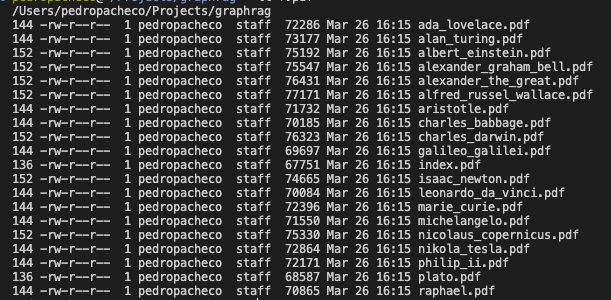

### Now let's transform the PDF files into langchain Documents. This is a bit silly and there are more sophisticated ways to do this. Two thing sto keep in mind is that langchain Documents are in memory objects, and it is the glue that holds the different langchain classes together

In [ ]:
import os
from langchain_community.document_loaders import PyPDFLoader

pdf_dir = "/Users/pedropacheco/Projects/graphrag"
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]

pages = []
for file in pdf_files:
    path = os.path.join(pdf_dir, file)
    loader = PyPDFLoader(path)
    async for page in loader.alazy_load():
        pages.append(page)

print(f"✅ Loaded {len(pages)} pages from {len(pdf_files)} PDF files")


### Let's examine one of the documents. Note the type of the object. It isn't a python json object but a langhain Document

In [ ]:
import json

def print_document(document):
    print(f"Document type: {type(document)}")
    
    print("Content:")
    print(document.page_content)  # Print the text content

    print("\nMetadata:")
    print(json.dumps(document.metadata, indent=4))  # Pretty-print the metadata dictionary
print_document(pages[0])


### Pay particular attention to the metadata section. Note that pypdf was kind enough to generate some level of metadata, but it is purely structural, not semanatic. In the next step we will use a Datastax GraphRAG "transformer" to extract labels based on keywords. Because I am a history buff, I am using middle school level "who was" https://www.whowasbookseries.com/who-was/ books and will perform name entity recognition using the KeyBERT model. While the underlying technology is fairly sophisiticated, our implementation makes it easy to use. 

In [ ]:
from gliner import GLiNER
from langchain_graph_retriever.transformers.gliner import GLiNERTransformer

gliner = GLiNERTransformer(labels=["associates", "places", "dates", "events"])

gliner_documents = gliner.transform_documents(documents=pages)
print_document(gliner_documents[0])


### NER isn't an exact science and results will vary. Datastax Graph RAG offer a few alternatives, but feel free to use other models or methodologies. IMHO, metadata extraction is the key to your graph rag success. Let's look at alternatives

In [ ]:
from keybert import KeyBERT
import copy
# Initialize KeyBERT model
kw_model = KeyBERT()
keybert_documents = copy.deepcopy(pages)
for doc in keybert_documents:
    # Extract keywords from the page_content
    keywords = kw_model.extract_keywords(
        doc.page_content, keyphrase_ngram_range=(1, 2), stop_words="english"
    )

    # Add the filtered keywords to the metadata
    doc.metadata["keywords"] = keywords

print_document(keybert_documents[0])
    

### And if you are inclined, you can always use the an LLM to extract keywords from the document. Remember that this is quite an expensive operation

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.documents import Document
import copy

# Initialize the OpenAI chat model
llm = ChatOpenAI(model="gpt-4", temperature=0)

# Define the prompt template
prompt_template = """
Extract named entities from the following text.
Categorize them into predefined types such as PEOPLE, PLACES, DATES, EVENTS.
Provide the entities and their corresponding types as a structured JSON response.

If there is more than one value for the same entity type, create an array of entity names.

[START OF TEXT]
{text}
[END OF TEXT]

The response format should be a json, where the key is the category, and the value is what you extracted. 
"""

prompt = PromptTemplate(input_variables=["text"], template=prompt_template)

# Create an LLM chain
chain = LLMChain(llm=llm, prompt=prompt)

def extract_named_entities(documents):
    
    for document in documents:
        response = chain.run({"text": document.page_content})
        
        # Parse the response string into a JSON object
        try:
            entities = json.loads(response)  # Convert the string to a JSON object
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for document {document.id}: {e}")
            entities = {}  
        yield entities

# Extract named entities
llm_ner_documents = copy.deepcopy(pages)

for document, entities in zip(llm_ner_documents, extract_named_entities(llm_ner_documents)):
    document.metadata.update(entities)


In [ ]:
print_document(llm_ner_documents[18])


### The best possible result comes from using the LLM. Both gliner and keybert are smaller local models, so it is understandable why the LLM gives a more complete extraction. In the other hand, it is slower and more expensive.

### Now lets finally save one of the document set into the Vector Store. I will go with the documents enriched by the LLM. We also need an embedding to take advantage of Langchain fromDocument method.

In [ ]:
from langchain_openai import OpenAIEmbeddings
import os

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
# Test text for embedding
test_text = "This is a test sentence."

# Generate the embedding
embedding_vector = embedding_model.embed_query(test_text)

# Measure the length of the vector
vector_length = len(embedding_vector)

# Output results
print(f"Generated Embedding Vector Length: {vector_length}")


### Be careful. This cell truncates the collection

In [ ]:
from langchain_astradb import AstraDBVectorStore

vectorstore = AstraDBVectorStore(
    collection_name=os.getenv("ASTRA_DB_COLLECTION"),
    namespace=os.getenv("ASTRA_DB_KEYSPACE"),
    embedding=embedding_model,
)
vectorstore.astra_env.collection.delete_all()


### Now we add the documents

In [ ]:
vectorstore.add_documents(llm_ner_documents)


### The data has been saved to AstraDB. Now let's do the tradicional vector search

In [ ]:
import pprint

query_text = "Information about Plato"
results = vectorstore.similarity_search(query_text, k=3)
for plato in results:
    print(plato.page_content)
    pprint.pprint(plato.metadata)
    print("-------------------")


### Now let's setup a simple graph retriever using the PLACES metadata item and an edge equality rule and traverse

In [ ]:
from graph_retriever.strategies import Eager
from langchain_graph_retriever import GraphRetriever

# All siblings of the query node.
# k=10 total result set size
# start_k=1 closest document from vector search
# depth=2 depth of the graph to search
simple = GraphRetriever(
    store=vectorstore,
    edges=[("PLACES", "PLACES")],
    strategy=Eager(k=10, start_k=3, max_depth=2),
)

results = simple.invoke("Information about Plato")

for doc in results:
    places = doc.metadata.get("PLACES")
    pprint.pprint(f"{doc.page_content} \n {places}")
    print("-------------------")


### Now let's use the same data we already have using the PEOPLE metadata item and an edge equality rule and traverse

In [ ]:
# All siblings of the query node.
# k=10 total result set size
# start_k=1 closest document from vector search
# depth=2 depth of the graph to search
by_people = GraphRetriever(
    store=vectorstore,
    edges=[("PEOPLE", "PEOPLE")],
    strategy=Eager(k=10, start_k=3, max_depth=2),
)

results = by_people.invoke("Information about Greece")

for doc in results:
    people = (
        doc.metadata.get("PEOPLE")
    )
    pprint.pprint(f"{doc.page_content} \n {people}")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from langchain_graph_retriever.document_graph import create_graph


def plot_document_graph(documents, edges):
    document_graph = create_graph(
        documents=documents,
        edges=edges,
    )

    nx.draw(document_graph, with_labels=True)
    plt.show()


In [ ]:
results = by_people.invoke("Information about Einstein")
plot_document_graph(results, by_people.edges)
